In [1]:
import pandas as pd

DATA_FILE = "../data/yasa/zmax.parquet"

df = pd.read_parquet(DATA_FILE)

In [2]:
unique_counts = {}
for dataset in df.index.get_level_values(0).unique():
    subset = df.loc[dataset]
    unique_combinations = subset.index.unique()
    unique_counts[dataset] = len(unique_combinations)

for dataset, count in unique_counts.items():
    print(f"{dataset}: {count}")

total_count = sum(unique_counts.values())
print(f"Total unique combinations across all datasets: {total_count}")

Donders2018: 6
Donders2022: 72
Karolinska: 13
QS: 43
Total unique combinations across all datasets: 134


In [2]:
cols_all = df.columns
cols_time = cols_all[cols_all.str.startswith('time_')].tolist()
# EEG also includes the time columns
cols_eeg = cols_all[cols_all.str.startswith('eeg_')].tolist() + cols_time  
cols_eog = cols_all[cols_all.str.startswith('eog_')].tolist()

In [3]:
from lightgbm import LGBMClassifier

params = dict(
    boosting_type='gbdt',
    n_estimators=400,
    max_depth=5,
    num_leaves=90,
    colsample_bytree=0.5,
    importance_type='gain',
)
    

ImportError: libscipy_openblas-c128ec02.so: failed to map segment from shared object

In [ ]:
class_weight = "custom"

if class_weight == "custom":
    # See output/classifiers/gridsearch_class_weights.xlsx
    params['class_weight'] = {'N1': 2.2, 'N2': 1, 'N3': 1.2, 'R': 1.4, 'W': 1}
else:
    params['class_weight'] = class_weight

In [1]:
from zmax_datasets.datasets.base import ZMaxRecording
from zmax_datasets.exports.usleep import DataTypeMapping
from zmax_datasets.exports.utils import fir_filter, l2_normalize, clip_noisy_values, detect_peaks, extract_ibi, extract_hrv
from pathlib import Path

recording = ZMaxRecording("s1", "n1", Path("/project/3013097.06/Data/s1/n1/zmax"))

In [16]:
raw = recording.read_raw_data("OXY_IR_AC")
data = raw.get_data().squeeze()
data.shape

Extracting EDF parameters from /project/3013097.06/Data/s1/n1/zmax/OXY_IR_AC.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


(8084480,)

In [17]:
data = fir_filter(data, raw.info["sfreq"], 0.5, 4)
data.shape

Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 4.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 5.00 Hz)
- Filter length: 1691 samples (6.605 s)



(8084480,)

In [18]:
peaks = detect_peaks(data, raw.info["sfreq"])
peaks.shape

(37781,)

In [19]:
ibi = extract_ibi(peaks, raw.info["sfreq"])
ibi.shape

(37780,)

In [20]:
hrv = extract_hrv(data, raw.info["sfreq"])
hrv.shape

(37780,)

In [21]:
import numpy as np
x = np.interp(np.arange(len(data)), peaks[1:], hrv)
x.shape

(8084480,)

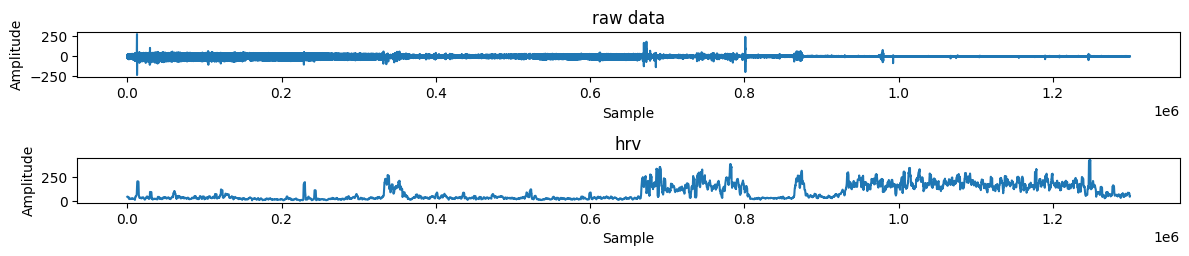

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot raw data
plt.subplot(5, 1, 1)
plt.plot(data[300000:1600000])
plt.title('raw data')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

# Plot raw data
plt.subplot(5, 1, 2)
plt.plot(x[300000:1600000])
plt.title('hrv')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [12]:
mapping = DataTypeMapping("dX", ["dX"], 
                          transforms=[
                            (
                                fir_filter,
                                {
                                    "sampling_frequency": 256,
                                    "high_cutoff": 5,
                                },
                            ),
                        ])

dX = mapping.map(recording, 128)[:20000]

mapping = DataTypeMapping("dY", ["dY"], 
                          transforms=[
                            (
                                fir_filter,
                                {
                                    "sampling_frequency": 256,
                                    "high_cutoff": 5,
                                },
                            ),
                        ])

dY = mapping.map(recording, 128)[:20000]

mapping = DataTypeMapping("dZ", ["dZ"], 
                          transforms=[
                            (
                                fir_filter,
                                {
                                    "sampling_frequency": 256,
                                    "high_cutoff": 5,
                                },
                            ),
                        ])

dZ = mapping.map(recording, 128)[:20000]

mapping = DataTypeMapping("movement", ["dX", "dY", "dZ"], 
                          transforms=[
                            (
                                fir_filter,
                                {
                                    "sampling_frequency": 256,
                                    "high_cutoff": 5,
                                },
                            ),
                            l2_normalize,
                        ])

mov = mapping.map(recording, 128)[:20000]

mapping = DataTypeMapping("mov", ["dX", "dY", "dZ"], 
                          transforms=[
                            (
                                fir_filter,
                                {
                                    "sampling_frequency": 256,
                                    "high_cutoff": 5,
                                },
                            ),
                            l2_normalize,
                        ])

mov_clipped = mapping.map(recording, 128)[:20000]

Extracting EDF parameters from /project/3013097.06/Data/s1/n1/zmax/dX.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up low-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 5.00 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Filter length: 423 samples (1.652 s)

Extracting EDF parameters from /project/3013097.06/Data/s1/n1/zmax/dY.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Setting up low-pass filter at 5 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper pas

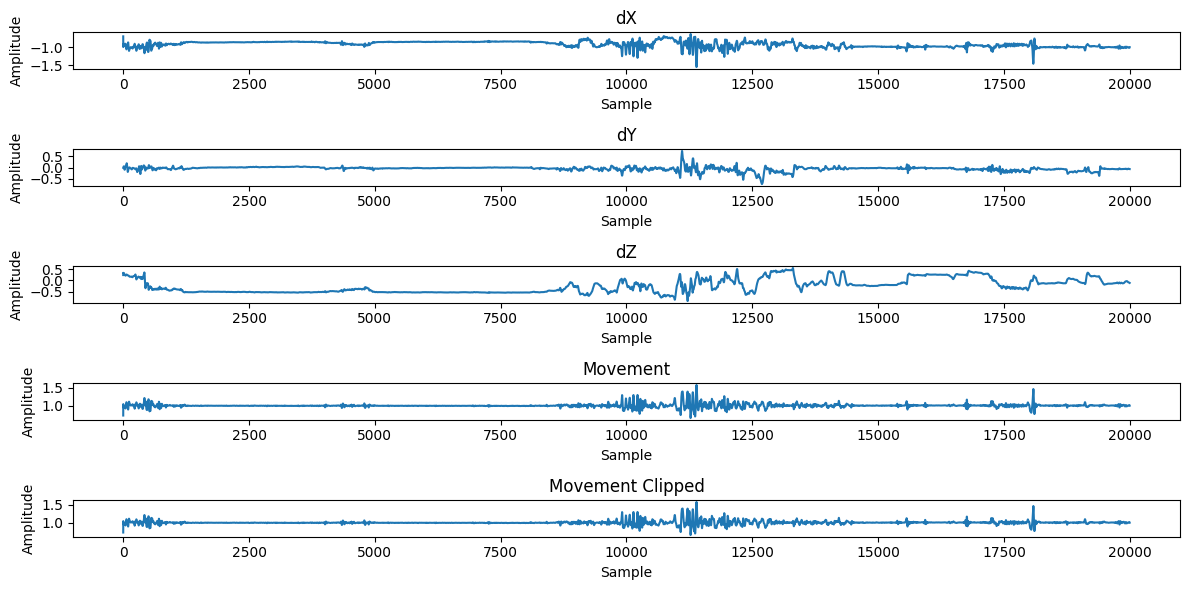

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot raw data
plt.subplot(5, 1, 1)
plt.plot(dX)
plt.title('dX')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 2)
plt.plot(dY)
plt.title('dY')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 3)
plt.plot(dZ)
plt.title('dZ')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 4)
plt.plot(mov)
plt.title('Movement')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.subplot(5, 1, 5)
plt.plot(mov_clipped)
plt.title('Movement Clipped')
plt.xlabel('Sample')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()
